In [1]:
import os
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
from requests.auth import HTTPBasicAuth
from client import client_id, client_secret

In [2]:
rootdir = Path('Top Country CSV')

file_list = [f for f in rootdir.glob("*.csv") if f.is_file()]

In [3]:
token_url = "https://accounts.spotify.com/api/token"
headers = {'content-type': 'application/x-www-form-urlencoded'}

token_params = {"grant_type" : "client_credentials"}

token_json = requests.post(token_url, params = token_params, headers = headers, auth = (client_id, client_secret)).json()
token = token_json['access_token']

In [4]:
token_headers = {'authorization': f"Bearer {token}"}

country = []
pop_popularity = []
rap_popularity = []
trap_popularity = []
other_popularity = []

search_artist_url = "https://api.spotify.com/v1/artists/"

for file in file_list:
    country_name = str(file).split("\\")[-1].split("_")[0]
    country.append(country_name)
          
    excel_df = pd.read_csv(file)
    
    pop_popularity.append(0)
    rap_popularity.append(0)
    trap_popularity.append(0)
    other_popularity.append(0)
    
    for artist_id in excel_df["Artist ID"]:
        artist_url = search_artist_url + artist_id
        
        time.sleep(0.01)
        
        try:
            artist_json = requests.get(artist_url, headers = token_headers).json()
            genres = artist_json["genres"]
            
            if "pop" in genres and "rap" in genres and "trap music" in genres:
                pop_popularity[country.index(country_name)] += 1
                rap_popularity[country.index(country_name)] += 1
                trap_popularity[country.index(country_name)] += 1
                
            elif "pop" in genres and "rap" in genres:
                pop_popularity[country.index(country_name)] += 1
                rap_popularity[country.index(country_name)] += 1
                
            elif "pop" in genres and "trap music" in genres:
                pop_popularity[country.index(country_name)] += 1
                trap_popularity[country.index(country_name)] += 1
            
            elif "rap" in genres and "trap music" in genres:
                rap_popularity[country.index(country_name)] += 1
                trap_popularity[country.index(country_name)] += 1
                
            elif "pop" in genres:
                pop_popularity[country.index(country_name)] += 1
                
            elif "rap" in genres:
                rap_popularity[country.index(country_name)] += 1
                
            elif "trap music" in genres:
                trap_popularity[country.index(country_name)] += 1

            else:
                other_popularity[country.index(country_name)] += 1
                
        except (KeyError, IndexError):
            print(f"Artist ID not working | {artist_id}")

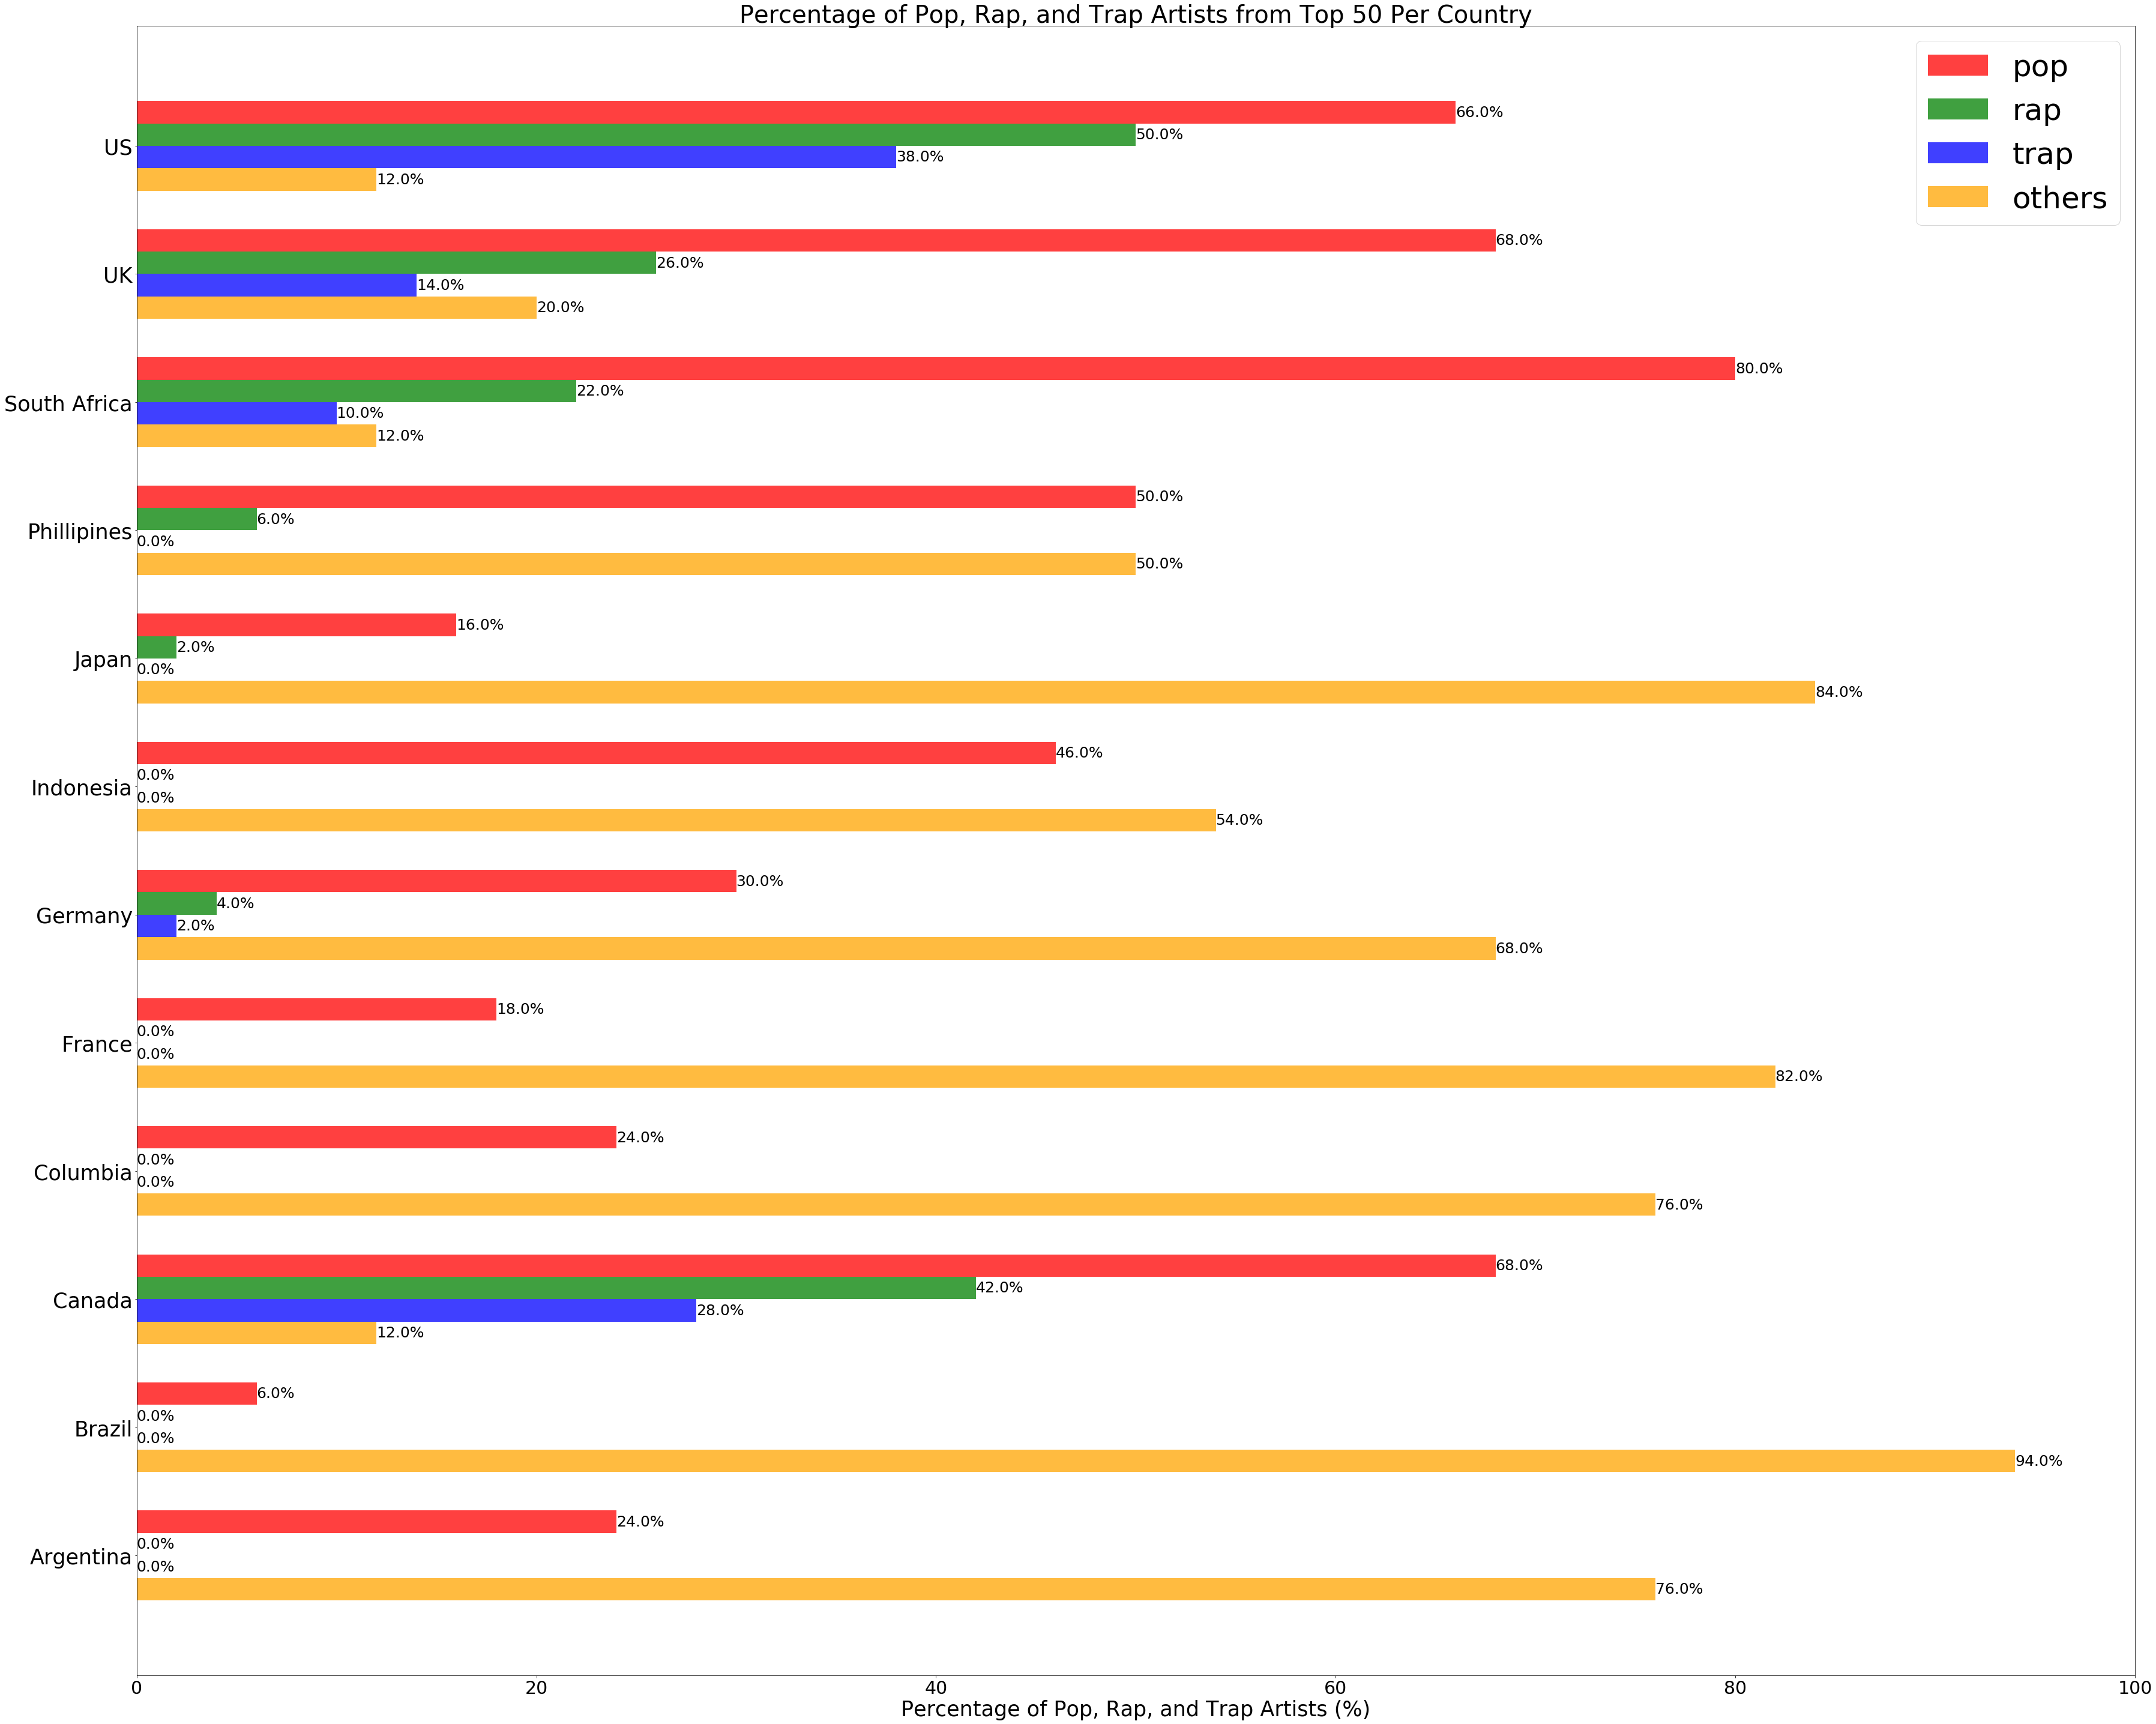

In [5]:
fig, ax = plt.subplots(figsize = (50,40))

y_axis = np.arange(0, len(country) * 4, 4)
width = 0.7

x_axis_pop = (np.array(pop_popularity)/50) * 100
x_axis_rap = (np.array(rap_popularity)/50) * 100
x_axis_trap = (np.array(trap_popularity)/50) * 100
x_axis_other = (np.array(other_popularity)/50) * 100

ax.barh(y_axis + width + width/2, x_axis_pop, width, color = 'r', alpha = 0.75, label = "pop")
ax.barh(y_axis + width/2, x_axis_rap, width, color = 'g', alpha = 0.75, label = "rap")
ax.barh(y_axis - width/2, x_axis_trap, width, color = 'b', alpha = 0.75, label = "trap")
ax.barh(y_axis - width - width/2, x_axis_other, width, color = 'orange', alpha = 0.75, label = "others")

plt.yticks(y_axis, country, Fontsize = 35)
plt.xticks(Fontsize = 30)
plt.xlim(0,100)
plt.xlabel("Percentage of Pop, Rap, and Trap Artists (%)", Fontsize = 35)
plt.title("Percentage of Pop, Rap, and Trap Artists from Top 50 Per Country", Fontsize = 40)
ax.legend(loc = "best", prop={'size': 50})

rects = ax.patches

for rect in rects:
    box_width = rect.get_height()
    height = rect.get_y() + box_width / 2
    width = rect.get_width()
    
    if width >= 0:
        ax.text(width, height, f'{round(width,2)}%', Fontsize = 25, ha = 'left', va = 'center')
    else:
        ax.text(width, height, f'{round(width,2)}%', Fontsize = 25, ha = 'right', va = 'center')

plt.savefig("Images/Percentage_of_Top_3_US_Genre_Per_Country.png")
       
plt.tight_layout()
    
plt.show()